In [1]:
# MiDaS : https://github.com/intel-isl/MiDaS
# https://paperswithcode.com/dataset/redweb
# !pip install timm
!pip install --upgrade torch torchvision

^C


In [2]:
#import collections.abc as container_abcs
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/nael/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/nael/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/nael/.cache/torch/hub/intel-isl_MiDaS_master


In [6]:
def predict_depth(input_model):
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    # ===== Tensor to numpy
    return(prediction.cpu().numpy())
    
def convert_to_image(depth_map):
    # ===== R -> {0,1,...,255}
    mean = np.mean(depth_map)
    std = np.std(depth_map)
    output = (depth_map-mean)/(std)
    output = output - np.min(output)
    output = 255*output/np.max(output)
    output = output.astype('uint8')
    return(output)

def draw_target(img):
    h, w = img.shape[:2]
    y_target = int(h/2)
    x_target = int(w/2)
    cv2.line(img, pt1=(0, y_target), pt2=(w ,y_target), color=(0,255,0), thickness=2)
    cv2.line(img, pt1=(x_target, 0), pt2=(x_target, h), color=(0,255,0), thickness=2)
    cv2.circle(img, center=(x_target, y_target), radius=10, color=(0,0,255), thickness=2)
    return(img)

y = np.array([1, 1.5, 2, 2.5, 3]) # Mesure a la main en metres.
x = np.array([800, 650, 420, 290, 160]) # Prédiction moyennes associées aux mesures
distance = lambda x : (1120 - x)/328
    
def get_distance(depth):
    dist = distance(depth)
    output = ""
    if dist < 1:
        output = " < 1 m"
    elif dist > 3:
        output = " > 3 m"
    else:
        output = str(round(dist, 2))+" m"
    return(output)

In [ ]:
cam = cv2.VideoCapture(0)

while True:
    # ===== Get frame
    isTrue, original_frame = cam.read()
    original_frame = cv2.flip(original_frame, 1)
    # ===== Pre-process frame
    frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)
    input_batch = transform(frame).to(device)
    # ===== Prediction depth
    depthh = predict_depth(input_batch)
    depth = depthh
    # ===== Get depth target (center of the image)
    h, w = depth.shape[:2]
    y_target = int(h/2)
    x_target = int(w/2)
    depth_target = get_distance(depth[y_target, x_target])
    # ===== R -> {0,1,...,255}
    depth = convert_to_image(depth)
    # ===== Convert to a colormap
    depth = cv2.applyColorMap(depth, cv2.COLORMAP_JET)
    cv2.putText(original_frame, "Prediction : " + str(round(depthh[y_target, x_target], 2)) + " (" + depth_target + ')' , (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 0, 0), 2)

    draw_target(original_frame)
    cv2.imshow("Video original", original_frame)
    cv2.imshow("Depth map", depth)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
cam.release()
cv2.destroyAllWindows()

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


In [26]:
cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)

array([[184, 184, 181, ..., 147, 149, 150],
       [185, 185, 184, ..., 148, 148, 148],
       [185, 185, 186, ..., 150, 149, 147],
       ...,
       [192, 192, 190, ..., 145, 145, 149],
       [192, 191, 190, ..., 144, 143, 147],
       [191, 191, 191, ..., 148, 145, 148]], dtype=uint8)

In [46]:
print("min : ", np.min(depthh))
print("max : ", np.max(depthh))

-48.76839
810.1122


In [51]:
original_frame

array([[[192, 191, 187],
        [192, 191, 187],
        [197, 195, 180],
        ...,
        [150, 153, 152],
        [152, 154, 154],
        [153, 155, 155]],

       [[193, 193, 186],
        [193, 193, 186],
        [198, 197, 179],
        ...,
        [152, 154, 154],
        [150, 155, 152],
        [151, 156, 153]],

       [[196, 195, 184],
        [195, 194, 183],
        [194, 195, 186],
        ...,
        [155, 155, 155],
        [153, 155, 155],
        [154, 156, 156]],

       ...,

       [[189, 189, 175],
        [188, 188, 174],
        [195, 191, 169],
        ...,
        [125, 121, 119],
        [127, 126, 121],
        [127, 126, 121]],

       [[196, 192, 170],
        [195, 191, 169],
        [196, 190, 168],
        ...,
        [125, 125, 125],
        [127, 127, 127],
        [126, 126, 126]],

       [[200, 193, 171],
        [200, 193, 171],
        [198, 192, 170],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]]

In [50]:
depthh

array([[548.3881 , 547.47656, 545.6673 , ..., 517.9994 , 480.13873,
        462.11923],
       [547.55023, 546.29065, 543.75366, ..., 528.0472 , 494.9025 ,
        479.242  ],
       [546.3119 , 544.15063, 539.7056 , ..., 549.5946 , 526.2767 ,
        515.5492 ],
       ...,
       [427.71375, 427.95514, 429.02487, ..., 458.98483, 456.64206,
        456.11633],
       [423.89908, 424.1787 , 425.04877, ..., 458.5852 , 456.2679 ,
        455.79608],
       [422.18246, 422.5094 , 423.36572, ..., 458.48007, 456.07343,
        455.58014]], dtype=float32)

error: OpenCV(4.5.2) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


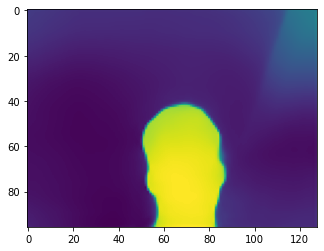

In [41]:
img = plt.imshow(output)
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

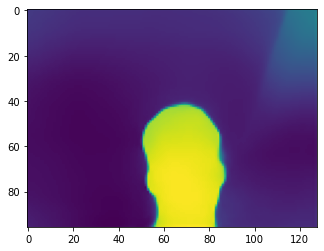

In [72]:
mean = np.mean(output)
std = np.std(output)
out = (output-mean)/(std)
out = out - np.min(out)
out = 255*out/np.max(out)
out = out.astype('int')
plt.imshow(out)

In [22]:
prediction = midas(input_batch)

In [23]:
prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

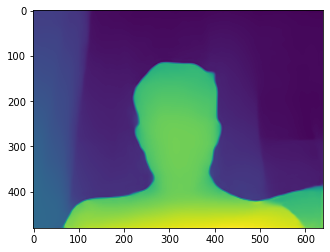

In [60]:
plt.imshow(output)

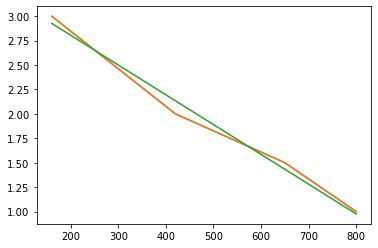

Text(0.5, 0, 'prédiction')

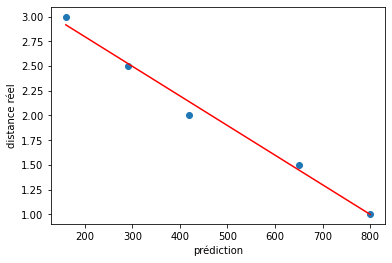

In [21]:
f = lambda x : 3.3982 - 0.003*x
plt.scatter(x,y)
plt.plot(x,f(x), c = "r")
plt.ylabel("distance réel")
plt.xlabel("prédiction")

In [16]:
5*1348600 - 2320*2320

1360600

In [ ]:
1360600